In [19]:
import pandas

data = pandas.read_csv('data.csv', usecols=range(1, 11))

data.head(n=5)

,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [48]:
data.loc[0]

Name                                        Martine of Martine's Table
City                                                         Amsterdam
Cuisine Style                          ['French', 'Dutch', 'European']
Ranking                                                              1
Rating                                                               5
Price Range                                                   $$ - $$$
Number of Reviews                                                  136
Reviews              [['Just like home', 'A Warm Welcome to Wintry ...
URL_TA               /Restaurant_Review-g188590-d11752080-Reviews-M...
ID_TA                                                        d11752080
Name: 0, dtype: object

In [36]:
isLjubljana = data['City'] == 'Ljubljana'
data_lj = data[isLjubljana]

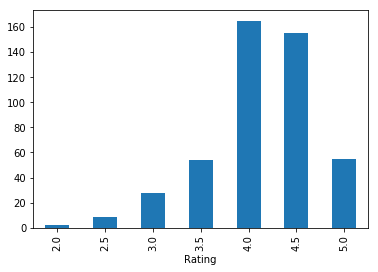

In [37]:
###############################################
# Restaurant rating distribution in Ljubljana #
###############################################

ratings_lj = data_lj['Rating']
vc = ratings_lj.value_counts().sort_index()
ax = vc.plot(kind='bar').set(xlabel="Rating")

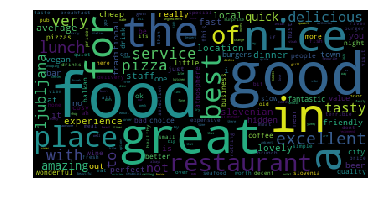

In [105]:
############################################################
# Review word occurence graph for restaurants in Ljubljana #
############################################################
import collections as col
import wordcloud
import nltk
import matplotlib.pyplot as plt

occurence_counter = col.Counter()

reviews_lj = data_lj['Reviews']
for revs_restaurant in reviews_lj:
    if not isinstance(revs_restaurant, str):
        continue
    words = revs_restaurant.split(' ');
    for w in words:
        parsed_word = ''.join(c for c in w if c.isalpha()).lower()
        if parsed_word == '':
            continue
        tagged = nltk.pos_tag([parsed_word])
        if not tagged[0][1].startswith('CC'):     # We want to avoid conjunctions
            occurence_counter[parsed_word] += 1
        
cloud = wordcloud.WordCloud()       
cloud = cloud.generate_from_frequencies(occurence_counter)     


plt.imshow(cloud)
plt.axis("off")
plt.show()
